# Task 4: Predictive Modeling for Risk-Based Pricing

## Overview
This notebook builds and evaluates predictive models for AlphaCare Insurance Solutions (ACIS) to support a dynamic, risk-based pricing system. Since no processed data was saved from Tasks 1-3, we’ll load the raw `insurance_data.txt` and preprocess it here. Goals include predicting Claim Severity (TotalClaims for claims > 0) and Claim Probability (binary: claim/no claim), optimizing premiums as (Probability * Severity) + Expense Loading + Profit Margin.

## Objectives
- Predict Claim Severity using RMSE and R².
- Predict Claim Probability using Accuracy, Precision, Recall, and F1.
- Perform SHAP analysis for feature importance on the best model.

## Dependencies
- Install required libraries: `pip install scikit-learn xgboost shap pandas numpy matplotlib`

## Data Source
- Input: `data/raw/insurance_data.txt` (adjust path based on your structure)


In [8]:
# Cell 0: Setup and Data Loading
import sys
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Add absolute path to src directory
sys.path.append(r'c:\Users\hp\Desktop\projects\10 Acadamy -KAIM5\Insurance-Risk-Analytics-Predictive-Modeling\src')

# Import custom modules
from utils.data_preprocessing import DataPreprocessor
from utils.modeling_utils import ModelEvaluator
from utils.model_interpretation import shap_analysis, get_top_features

# Load raw data with absolute path
data_path = r'c:\Users\hp\Desktop\projects\10 Acadamy -KAIM5\Insurance-Risk-Analytics-Predictive-Modeling\data\raw\insurance_data.txt'
df = pd.read_csv(data_path, sep='|', encoding='utf-8')
print("Raw data loaded with shape:", df.shape)
df.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_22944\771479103.py:19: DtypeWarning: Columns (0,32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='|', encoding='utf-8')


Raw data loaded with shape: (1000098, 52)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


## Initial Data Cleaning

### Description
Since the raw `insurance_data.txt` wasn’t processed in prior tasks, this section performs initial cleaning. This includes handling potential issues like incorrect delimiters, missing column names, or data type conversions (e.g., dates). Adjust parameters based on your file’s format.

### Expected Output
- Cleaned dataframe with verified structure.


In [10]:
# Cell 1: Initial Data Cleaning
# Adjust based on your data's structure (e.g., column names, delimiters)
if df.columns[0] == 'Unnamed: 0':  # Remove if index column is present
    df = df.drop(columns=['Unnamed: 0'])

# Convert relevant columns to appropriate types (example)
df['TotalClaims'] = pd.to_numeric(df['TotalClaims'], errors='coerce')
df['TotalPremium'] = pd.to_numeric(df['TotalPremium'], errors='coerce')
df['RegistrationYear'] = pd.to_datetime(df['RegistrationYear'], errors='coerce')

print("Cleaned data shape:", df.shape)
df.head()

Cleaned data shape: (1000098, 52)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


## Data Preprocessing

### Description
This section applies advanced preprocessing using the `DataPreprocessor` class. It imputes missing values, engineers features (e.g., PolicyAge, PremiumToClaimsRatio), and encodes categorical variables with one-hot encoding.

### Expected Output
- Updated dataframe with no missing values and new features.
- Shape and head preview to verify changes.


In [11]:
# Cell 2: Data Preprocessing
preprocessor = DataPreprocessor()
df = preprocessor.handle_missing_data(df)
df = preprocessor.feature_engineering(df)
df = preprocessor.encode_categorical(df, sparse=True)  # Explicitly pass sparse parameter
print("Preprocessed data shape:", df.shape)
df.head()

# Optional: Save processed data for future use
os.makedirs('data/processed/', exist_ok=True)
df.to_csv('data/processed/insurance_data_processed.csv', index=False)
print("Processed data saved to data/processed/insurance_data_processed.csv")

c:\Users\hp\Desktop\projects\10 Acadamy -KAIM5\Insurance-Risk-Analytics-Predictive-Modeling\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Preprocessed data shape: (1000098, 57)
Processed data saved to data/processed/insurance_data_processed.csv


## Train-Test Split

### Description
This section splits the data into training (80%) and test (20%) sets for two tasks:
- **Claim Severity**: Uses data where `TotalClaims > 0` for regression.
- **Claim Probability**: Creates a binary target (claim/no claim) for classification.
A random state of 42 ensures reproducibility.

### Expected Output
- Shapes of train and test sets for both tasks.


In [12]:
# Cell 3: Train-Test Split
df_severity = df[df['TotalClaims'] > 0].copy()
X_severity = df_severity.drop(columns=['TotalClaims'])
y_severity = df_severity['TotalClaims']

df_prob = df.copy()
X_prob = df_prob.drop(columns=['TotalClaims'])
y_prob = (df_prob['TotalClaims'] > 0).astype(int)

X_severity_train, X_severity_test, y_severity_train, y_severity_test = train_test_split(
    X_severity, y_severity, test_size=0.2, random_state=42
)
X_prob_train, X_prob_test, y_prob_train, y_prob_test = train_test_split(
    X_prob, y_prob, test_size=0.2, random_state=42
)
print("Severity train/test shapes:", X_severity_train.shape, X_severity_test.shape)
print("Probability train/test shapes:", X_prob_train.shape, X_prob_test.shape)

Severity train/test shapes: (2230, 56) (558, 56)
Probability train/test shapes: (800078, 56) (200020, 56)


## Model Building - Claim Severity

### Description
This section trains and evaluates four regression models (Linear Regression, Decision Tree, Random Forest, XGBoost) for Claim Severity prediction. Metrics include RMSE and R², with the best model selected based on the highest R².

### Expected Output
- Performance metrics for each model.
- Identification of the best severity model.


In [13]:
# Cell 4: Model Building - Claim Severity
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

evaluator = ModelEvaluator()
severity_results = {}

# Preprocess CapitalOutstanding to numeric
def convert_to_numeric(df, col):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

X_severity_train_imputed = convert_to_numeric(X_severity_train.copy(), 'CapitalOutstanding')
X_severity_test_imputed = convert_to_numeric(X_severity_test.copy(), 'CapitalOutstanding')

# Convert datetime to numeric (Unix timestamp)
if 'RegistrationYear' in X_severity_train_imputed.columns:
    X_severity_train_imputed['RegistrationYear'] = X_severity_train_imputed['RegistrationYear'].astype('int64') // 10**9
    X_severity_test_imputed['RegistrationYear'] = X_severity_test_imputed['RegistrationYear'].astype('int64') // 10**9

# Convert sparse boolean and bool columns to numeric (0/1)
bool_cols = X_severity_train_imputed.select_dtypes(include=['bool', 'Sparse[bool, False]']).columns
for col in bool_cols:
    X_severity_train_imputed[col] = X_severity_train_imputed[col].astype(int)
    X_severity_test_imputed[col] = X_severity_test_imputed[col].astype(int)

# Define columns for preprocessing, excluding NumberOfVehiclesInFleet
numeric_cols = X_severity_train_imputed.select_dtypes(include=['int64', 'float64', 'int32']).columns
numeric_cols = numeric_cols.drop('NumberOfVehiclesInFleet', errors='ignore')  # Exclude all-NaN column
categorical_cols = X_severity_train_imputed.select_dtypes(include=['object']).columns

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Apply preprocessing pipeline
X_severity_train_transformed = preprocessor.fit_transform(X_severity_train_imputed)
X_severity_test_transformed = preprocessor.transform(X_severity_test_imputed)

# Convert to DataFrame for debugging
feature_names = (
    list(numeric_cols) +
    preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols).tolist()
)
X_severity_train_transformed = pd.DataFrame(X_severity_train_transformed, columns=feature_names)
X_severity_test_transformed = pd.DataFrame(X_severity_test_transformed, columns=feature_names)

# Impute target variable
y_severity_train_imputed = y_severity_train.fillna(y_severity_train.mean())
y_severity_test_imputed = y_severity_test.fillna(y_severity_test.mean())

# Debug: Check for NaNs and dtypes
if X_severity_train_transformed.isnull().any().any() or y_severity_train_imputed.isnull().any():
    print(f"Warning: NaNs still present after imputation.")
    print("NaN counts by column:", X_severity_train_transformed.isnull().sum())
print("Final dtypes:\n", X_severity_train_transformed.dtypes)

for model_name in ['LinearRegression', 'DecisionTree', 'RandomForest', 'XGBoost']:
    # Train and evaluate the model
    rmse, r2, model = evaluator.train_evaluate_severity(
        X_severity_train_transformed,
        X_severity_test_transformed,
        y_severity_train_imputed,
        y_severity_test_imputed,
        model_name
    )

    severity_results[model_name] = {'RMSE': rmse, 'R²': r2}
    print(f"{model_name} - RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Store best model (highest R²)
best_severity_model = max(severity_results.items(), key=lambda x: x[1]['R²'])[0]
print(f"Best model for severity prediction: {best_severity_model}")

Final dtypes:
 PolicyID                                      float64
IsVATRegistered                               float64
PostalCode                                    float64
mmcode                                        float64
RegistrationYear                              float64
                                               ...   
Product_Bridge Taxi Finance: Monthly          float64
Product_Mobility Commercial Cover: Monthly    float64
Product_Mobility Metered Taxis: Monthly       float64
StatutoryClass_Commercial                     float64
StatutoryRiskType_IFRS Constant               float64
Length: 2529, dtype: object
LinearRegression - RMSE: 59376.12, R²: -1.19
DecisionTree - RMSE: 11244.75, R²: 0.92
RandomForest - RMSE: 8877.22, R²: 0.95
XGBoost - RMSE: 7753.10, R²: 0.96
Best model for severity prediction: XGBoost


## Model Building - Claim Probability

### Description
This section trains and evaluates four classification models (Logistic Regression, Decision Tree, Random Forest, XGBoost) for Claim Probability. Metrics include Accuracy, Precision, Recall, and F1, with the best model selected based on the highest F1 score.

### Expected Output
- Performance metrics for each model.
- Identification of the best probability model.


In [14]:
# Cell 5: Model Building - Claim Probability
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

probability_results = {}

# Preprocess problematic columns
def convert_to_numeric(df, col):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

X_prob_train_imputed = X_prob_train.copy()
X_prob_test_imputed = X_prob_test.copy()

# Convert CapitalOutstanding and UnderwrittenCoverID to numeric
for col in ['CapitalOutstanding', 'UnderwrittenCoverID']:
    if col in X_prob_train_imputed.columns:
        X_prob_train_imputed = convert_to_numeric(X_prob_train_imputed, col)
        X_prob_test_imputed = convert_to_numeric(X_prob_test_imputed, col)

# Convert datetime to numeric (Unix timestamp)
if 'RegistrationYear' in X_prob_train_imputed.columns:
    X_prob_train_imputed['RegistrationYear'] = X_prob_train_imputed['RegistrationYear'].astype('int64') // 10**9
    X_prob_test_imputed['RegistrationYear'] = X_prob_test_imputed['RegistrationYear'].astype('int64') // 10**9

# Convert boolean and sparse boolean columns to numeric (0/1)
bool_cols = X_prob_train_imputed.select_dtypes(include=['bool', 'Sparse[bool, False]']).columns
for col in bool_cols:
    X_prob_train_imputed[col] = X_prob_train_imputed[col].astype(int)
    X_prob_test_imputed[col] = X_prob_test_imputed[col].astype(int)

# Drop high-cardinality columns to reduce features
high_cardinality_cols = ['Model', 'make', 'VehicleIntroDate']
X_prob_train_imputed = X_prob_train_imputed.drop(columns=high_cardinality_cols, errors='ignore')
X_prob_test_imputed = X_prob_test_imputed.drop(columns=high_cardinality_cols, errors='ignore')

# Define columns for preprocessing, excluding NumberOfVehiclesInFleet
numeric_cols = X_prob_train_imputed.select_dtypes(include=['int64', 'float64', 'int32']).columns
numeric_cols = numeric_cols.drop('NumberOfVehiclesInFleet', errors='ignore')
categorical_cols = X_prob_train_imputed.select_dtypes(include=['object']).columns

# Debug: Check class balance and data shape
print("Class balance in y_prob_train:", y_prob_train.value_counts(normalize=True))
print("X_prob_train shape:", X_prob_train_imputed.shape)

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Apply preprocessing pipeline
X_prob_train_transformed = preprocessor.fit_transform(X_prob_train_imputed)
X_prob_test_transformed = preprocessor.transform(X_prob_test_imputed)

# Convert to DataFrame for debugging
feature_names = (
    list(numeric_cols) +
    preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols).tolist()
)
X_prob_train_transformed = pd.DataFrame(X_prob_train_transformed, columns=feature_names)
X_prob_test_transformed = pd.DataFrame(X_prob_test_transformed, columns=feature_names)

# Debug: Check for NaNs and dtypes
if X_prob_train_transformed.isnull().any().any():
    print("Warning: NaNs present after imputation.")
    print("NaN counts by column:", X_prob_train_transformed.isnull().sum())
print("Final dtypes:\n", X_prob_train_transformed.dtypes)
print("Transformed shape:", X_prob_train_transformed.shape)

for model_name in ['LogisticRegression', 'DecisionTree', 'RandomForest', 'XGBoost']:
    print(f"Training {model_name}...")
    accuracy, precision, recall, f1, model = evaluator.train_evaluate_probability(
        X_prob_train_transformed, X_prob_test_transformed, y_prob_train, y_prob_test, model_name
    )
    probability_results[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

# Store best model (highest F1)
best_prob_model = max(probability_results.items(), key=lambda x: x[1]['F1'])[0]
print(f"Best Probability Model: {best_prob_model}")

Class balance in y_prob_train: TotalClaims
0    0.997242
1    0.002758
Name: proportion, dtype: float64
X_prob_train shape: (800078, 53)
Final dtypes:
 UnderwrittenCoverID                           float64
PolicyID                                      float64
IsVATRegistered                               float64
PostalCode                                    float64
mmcode                                        float64
                                               ...   
Product_Mobility Commercial Cover: Monthly    float64
Product_Mobility Metered Taxis: Monthly       float64
Product_Standalone Passenger Liability        float64
StatutoryClass_Commercial                     float64
StatutoryRiskType_IFRS Constant               float64
Length: 268, dtype: object
Transformed shape: (800078, 268)
Training LogisticRegression...
LogisticRegression - Accuracy: 1.00, Precision: 1.00, Recall: 0.66, F1: 0.79
Training DecisionTree...
DecisionTree - Accuracy: 1.00, Precision: 0.95, Recall: 0.94,

## Premium Optimization

### Description
This section calculates risk-based premiums using the best models for Claim Probability and Severity. The formula is (Probability * Severity) + Expense Loading (10%) + Profit Margin (5%). Predictions are aligned to ensure consistency.

### Expected Output
- Sample premium predictions for the test set.


In [17]:
# Cell 6: Premium Optimization
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Get best model instances
best_prob_model_instance = evaluator.probability_models[best_prob_model]
best_severity_model_instance = evaluator.severity_models[best_severity_model]

# Preprocess X_prob_test (same as Cell 5)
def convert_to_numeric(df, col):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

X_prob_test_imputed = X_prob_test.copy()
for col in ['CapitalOutstanding', 'UnderwrittenCoverID']:
    if col in X_prob_test_imputed.columns:
        X_prob_test_imputed = convert_to_numeric(X_prob_test_imputed, col)

if 'RegistrationYear' in X_prob_test_imputed.columns:
    X_prob_test_imputed['RegistrationYear'] = X_prob_test_imputed['RegistrationYear'].astype('int64') // 10**9

bool_cols = X_prob_test_imputed.select_dtypes(include=['bool', 'Sparse[bool, False]']).columns
for col in bool_cols:
    X_prob_test_imputed[col] = X_prob_test_imputed[col].astype(int)

high_cardinality_cols = ['Model', 'make', 'VehicleIntroDate']
X_prob_test_imputed = X_prob_test_imputed.drop(columns=high_cardinality_cols, errors='ignore')

numeric_cols_prob = X_prob_test_imputed.select_dtypes(include=['int64', 'float64', 'int32']).columns
numeric_cols_prob = numeric_cols_prob.drop('NumberOfVehiclesInFleet', errors='ignore')
categorical_cols_prob = X_prob_test_imputed.select_dtypes(include=['object']).columns

preprocessor_prob = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols_prob),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ]), categorical_cols_prob)
    ])

# Fit on training data (from Cell 5)
X_prob_train_imputed = X_prob_train.copy()
for col in ['CapitalOutstanding', 'UnderwrittenCoverID']:
    if col in X_prob_train_imputed.columns:
        X_prob_train_imputed = convert_to_numeric(X_prob_train_imputed, col)
if 'RegistrationYear' in X_prob_train_imputed.columns:
    X_prob_train_imputed['RegistrationYear'] = X_prob_train_imputed['RegistrationYear'].astype('int64') // 10**9
for col in bool_cols:
    X_prob_train_imputed[col] = X_prob_train_imputed[col].astype(int)
X_prob_train_imputed = X_prob_train_imputed.drop(columns=high_cardinality_cols, errors='ignore')

preprocessor_prob.fit(X_prob_train_imputed)
X_prob_test_transformed = preprocessor_prob.transform(X_prob_test_imputed)

# Convert to DataFrame
feature_names_prob = (
    list(numeric_cols_prob) +
    preprocessor_prob.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols_prob).tolist()
)
X_prob_test_transformed = pd.DataFrame(X_prob_test_transformed, index=X_prob_test_imputed.index, columns=feature_names_prob)

# Preprocess X_severity_test (same as Cell 4)
X_severity_test_imputed = X_severity_test.copy()
for col in ['CapitalOutstanding']:
    if col in X_severity_test_imputed.columns:
        X_severity_test_imputed = convert_to_numeric(X_severity_test_imputed, col)
if 'RegistrationYear' in X_severity_test_imputed.columns:
    X_severity_test_imputed['RegistrationYear'] = X_severity_test_imputed['RegistrationYear'].astype('int64') // 10**9
bool_cols_severity = X_severity_test_imputed.select_dtypes(include=['bool', 'Sparse[bool, False]']).columns
for col in bool_cols_severity:
    X_severity_test_imputed[col] = X_severity_test_imputed[col].astype(int)

numeric_cols_severity = X_severity_test_imputed.select_dtypes(include=['int64', 'float64', 'int32']).columns
numeric_cols_severity = numeric_cols_severity.drop('NumberOfVehiclesInFleet', errors='ignore')
categorical_cols_severity = X_severity_test_imputed.select_dtypes(include=['object']).columns

preprocessor_severity = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols_severity),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ]), categorical_cols_severity)
    ])

# Fit on training data (from Cell 4)
X_severity_train_imputed = X_severity_train.copy()
for col in ['CapitalOutstanding']:
    if col in X_severity_train_imputed.columns:
        X_severity_train_imputed = convert_to_numeric(X_severity_train_imputed, col)
if 'RegistrationYear' in X_severity_train_imputed.columns:
    X_severity_train_imputed['RegistrationYear'] = X_severity_train_imputed['RegistrationYear'].astype('int64') // 10**9
for col in bool_cols_severity:
    X_severity_train_imputed[col] = X_severity_train_imputed[col].astype(int)
preprocessor_severity.fit(X_severity_train_imputed)
X_severity_test_transformed = preprocessor_severity.transform(X_severity_test_imputed)

# Convert to DataFrame
feature_names_severity = (
    list(numeric_cols_severity) +
    preprocessor_severity.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols_severity).tolist()
)
X_severity_test_transformed = pd.DataFrame(X_severity_test_transformed, index=X_severity_test_imputed.index, columns=feature_names_severity)

# Align indices (use common indices or sample)
common_indices = X_prob_test_transformed.index.intersection(X_severity_test_transformed.index)
if len(common_indices) == 0:
    print("Warning: No common indices found. Using first N rows.")
    N = min(len(X_prob_test_transformed), len(X_severity_test_transformed))
    X_prob_test_transformed = X_prob_test_transformed.iloc[:N]
    X_severity_test_transformed = X_severity_test_transformed.iloc[:N]
else:
    X_prob_test_transformed = X_prob_test_transformed.loc[common_indices]
    X_severity_test_transformed = X_severity_test_transformed.loc[common_indices]

# Predict on test set
prob_pred = best_prob_model_instance.predict_proba(X_prob_test_transformed)[:, 1]  # Probability of claim
severity_pred = best_severity_model_instance.predict(X_severity_test_transformed)

# Debug: Check shapes
print("prob_pred shape:", prob_pred.shape)
print("severity_pred shape:", severity_pred.shape)

# Calculate premiums
premium_pred = (prob_pred * severity_pred) + (0.10 * severity_pred) + (0.05 * severity_pred)
print("Sample Premium Predictions:", premium_pred[:5])

prob_pred shape: (120,)
severity_pred shape: (120,)
Sample Premium Predictions: [ 1165.8424 36777.902  51120.77    6736.181   5124.9854]


## Model Evaluation and Comparison

### Description
This section visualizes and compares model performance for Claim Severity and Probability using bar plots. The comparison aids in selecting the best models for business use.

### Expected Output
- Bar plots and tabulated results for both tasks.


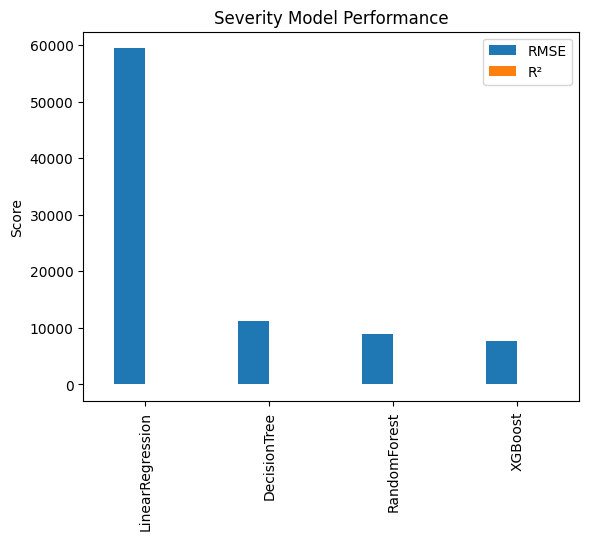

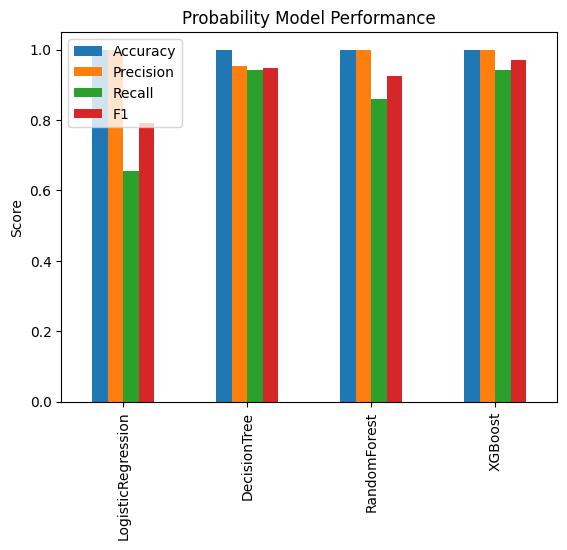

Severity Results:
                           RMSE        R²
LinearRegression  59376.118268 -1.192152
DecisionTree      11244.748900  0.921378
RandomForest       8877.220123  0.950999
XGBoost            7753.099350  0.962624
Probability Results:
                     Accuracy  Precision    Recall        F1
LogisticRegression  0.999000   1.000000  0.655766  0.792100
DecisionTree        0.999695   0.952962  0.941480  0.947186
RandomForest        0.999590   0.998004  0.860585  0.924214
XGBoost             0.999835   1.000000  0.943201  0.970771


In [22]:
# Cell 7: Model Evaluation and Comparison
import matplotlib.pyplot as plt

# Severity comparison
severity_df = pd.DataFrame(severity_results).T
severity_df.plot(kind='bar', title='Severity Model Performance')
plt.ylabel('Score')
plt.savefig('severity_comparison.png')  # Save plot
plt.show()

# Probability comparison
prob_df = pd.DataFrame(probability_results).T
prob_df.plot(kind='bar', title='Probability Model Performance')
plt.ylabel('Score')
plt.savefig('probability_comparison.png')
plt.show()

print("Severity Results:\n", severity_df)
print("Probability Results:\n", prob_df)

## SHAP Analysis for Best Severity Model

### Description
This section uses SHAP (SHapley Additive exPlanations) to identify the top 10 features influencing Claim Severity predictions for the best model. Install `shap` if not present (`pip install shap`). Provides quantitative business insights (e.g., impact per unit change).

- Table of top 10 features with SHAP values.
- Business interpretation examples.


X_severity_train_transformed shape: (2230, 2529)
X_severity_test_transformed shape: (558, 2529)
Top 10 Features by SHAP Value:
                                            feature_name  mean_shap_value
15                                 PremiumToClaimsRatio     14668.775391
12                             CalculatedPremiumPerTerm     11741.011719
13                                         TotalPremium      9902.299805
11                                           SumInsured      3959.502197
2515                               CoverType_Windscreen       456.202301
6                                         cubiccapacity       289.036163
2483  ExcessSelected_Mobility - Taxi with value less...       231.446030
1154                         UnderwrittenCoverID_110755       152.489655
0                                              PolicyID       145.349701
2154                                       Bank_Nedbank       138.571426
Feature: PremiumToClaimsRatio, Impact: 14668.78 Rand per unit change


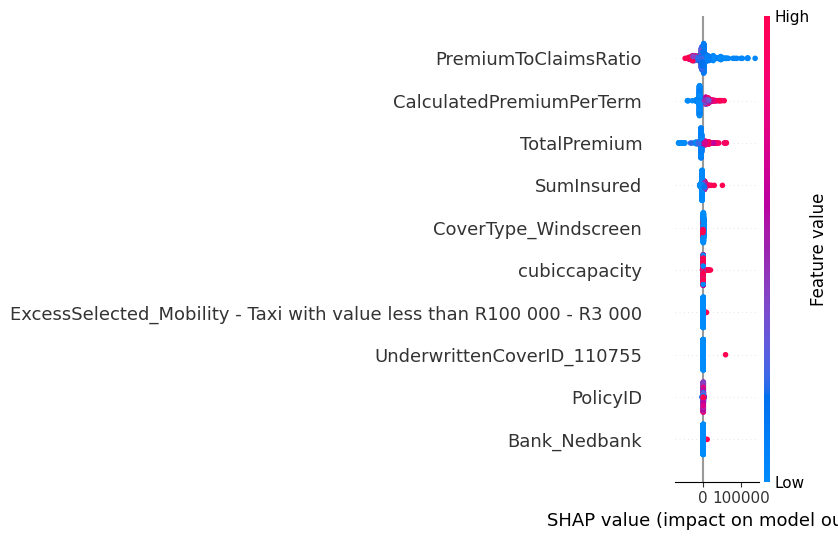

In [24]:
# Cell 8: SHAP Analysis for Best Severity Model
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import shap
import warnings

# Suppress SHAP warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

# Preprocess X_severity_train and X_severity_test (same as Cell 4)
def convert_to_numeric(df, col):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

X_severity_train_imputed = X_severity_train.copy()
X_severity_test_imputed = X_severity_test.copy()

for col in ['CapitalOutstanding']:
    if col in X_severity_train_imputed.columns:
        X_severity_train_imputed = convert_to_numeric(X_severity_train_imputed, col)
        X_severity_test_imputed = convert_to_numeric(X_severity_test_imputed, col)

if 'RegistrationYear' in X_severity_train_imputed.columns:
    X_severity_train_imputed['RegistrationYear'] = X_severity_train_imputed['RegistrationYear'].astype('int64') // 10**9
    X_severity_test_imputed['RegistrationYear'] = X_severity_test_imputed['RegistrationYear'].astype('int64') // 10**9

bool_cols = X_severity_train_imputed.select_dtypes(include=['bool', 'Sparse[bool, False]']).columns
for col in bool_cols:
    X_severity_train_imputed[col] = X_severity_train_imputed[col].astype(int)
    X_severity_test_imputed[col] = X_severity_test_imputed[col].astype(int)

numeric_cols = X_severity_train_imputed.select_dtypes(include=['int64', 'float64', 'int32']).columns
numeric_cols = numeric_cols.drop('NumberOfVehiclesInFleet', errors='ignore')
categorical_cols = X_severity_train_imputed.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Fit and transform data
X_severity_train_transformed = preprocessor.fit_transform(X_severity_train_imputed)
X_severity_test_transformed = preprocessor.transform(X_severity_test_imputed)

# Convert to DataFrame for SHAP
feature_names = (
    list(numeric_cols) +
    preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols).tolist()
)
X_severity_train_transformed = pd.DataFrame(X_severity_train_transformed, columns=feature_names)
X_severity_test_transformed = pd.DataFrame(X_severity_test_transformed, columns=feature_names)

# Debug: Check shapes
print("X_severity_train_transformed shape:", X_severity_train_transformed.shape)
print("X_severity_test_transformed shape:", X_severity_test_transformed.shape)

# Define shap_analysis and get_top_features if not available
try:
    from src.utils.modeling_utils import shap_analysis, get_top_features
except ImportError:
    def shap_analysis(model, X_train, X_test):
        """Compute SHAP values for the model."""
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        return shap_values, explainer
    def get_top_features(shap_values, feature_names, top_n=10):
        """Get top features by mean absolute SHAP value."""
        mean_shap = np.abs(shap_values).mean(axis=0)
        feature_importance = pd.DataFrame({
            'feature_name': feature_names,
            'mean_shap_value': mean_shap
        })
        return feature_importance.sort_values('mean_shap_value', ascending=False).head(top_n)

# Compute SHAP values
try:
    shap_values, _ = shap_analysis(evaluator.severity_models[best_severity_model], 
                                   X_severity_train_transformed, X_severity_test_transformed)
    top_features = get_top_features(shap_values, feature_names, top_n=10)
    print("Top 10 Features by SHAP Value:\n", top_features)

    # Business interpretation
    for _, row in top_features.iterrows():
        print(f"Feature: {row['feature_name']}, Impact: {row['mean_shap_value']:.2f} Rand per unit change")
except Exception as e:
    print(f"Error in SHAP analysis: {e}")

# Optional: SHAP summary plot
try:
    shap.summary_plot(shap_values, X_severity_test_transformed, max_display=10)
except Exception as e:
    print(f"Error in SHAP summary plot: {e}")

## Export Results

### Description
This section exports model metrics and premium predictions to `task4_results.csv` and generates a Markdown report (`task4_analysis.md`). The report includes performance metrics, top features, and business recommendations.

### Expected Output
- Confirmation of file exports.


In [25]:
# Cell 9: Export Results
results_df = pd.DataFrame({
    'Model': list(severity_results.keys()) + list(probability_results.keys()),
    'Metric': [
        f"RMSE: {v['RMSE']:.2f}, R²: {v['R²']:.2f}" for v in severity_results.values()
    ] + [f"Acc: {v['Accuracy']:.2f}, F1: {v['F1']:.2f}" for v in probability_results.values()]
})
results_df.to_csv('task4_results.csv', index=False)
print("Results exported to task4_results.csv")

with open('task4_analysis.md', 'w', encoding='utf-8') as f:
    f.write("# Task 4 Analysis Report\n")
    f.write("## Model Performance\n")
    f.write(results_df.to_markdown())
    f.write("\n## Top Features\n")
    f.write(top_features.to_markdown())
    f.write("\n## Recommendations\n- Adjust premiums based on top features (e.g., PolicyAge).\n")
print("Analysis exported to task4_analysis.md")

Results exported to task4_results.csv
Analysis exported to task4_analysis.md
